Step 1: Install Required Libraries

In [1]:

!pip install transformers
!pip install torch
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn



Step 2: Import Libraries

In [2]:


import ast
import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np




Step 3: Define Code Snippets

In [3]:
code_snippets = [
    """
def add(a, b):
    return a + b
""",
    """
class Calculator:
    def multiply(self, x, y):
        return x * y
""",
    """
import math
def circle_area(r):
    return math.pi * r ** 2
""",
    """
def fibonacci(n):
    if n <= 1:
        return n
    return fibonacci(n-1) + fibonacci(n-2)
""",
    """
def greet(name):
    print(f"Hello, {name}!")
""",
    """
class Person:
    def __init__(self, name):
        self.name = name
""",
    """
def factorial(n):
    result = 1
    for i in range(2, n+1):
        result *= i
    return result
""",
    """
import random
def roll_dice():
    return random.randint(1,6)
""",
    """
def is_prime(n):
    for i in range(2, int(n**0.5)+1):
        if n % i == 0:
            return False
    return True
""",
    """
def reverse_string(s):
    return s[::-1]
"""
]


Step 4: Parse AST & Extract Info

In [4]:
def extract_ast_info(code):
    tree = ast.parse(code)
    functions = [node.name for node in ast.walk(tree) if isinstance(node, ast.FunctionDef)]
    classes = [node.name for node in ast.walk(tree) if isinstance(node, ast.ClassDef)]
    imports = [node.names[0].name for node in ast.walk(tree) if isinstance(node, ast.Import)]
    return functions, classes, imports

ast_info = [extract_ast_info(code) for code in code_snippets]
for i, info in enumerate(ast_info):
    print(f"Snippet {i+1}: Functions={info[0]}, Classes={info[1]}, Imports={info[2]}")


Snippet 1: Functions=['add'], Classes=[], Imports=[]
Snippet 2: Functions=['multiply'], Classes=['Calculator'], Imports=[]
Snippet 3: Functions=['circle_area'], Classes=[], Imports=['math']
Snippet 4: Functions=['fibonacci'], Classes=[], Imports=[]
Snippet 5: Functions=['greet'], Classes=[], Imports=[]
Snippet 6: Functions=['__init__'], Classes=['Person'], Imports=[]
Snippet 7: Functions=['factorial'], Classes=[], Imports=[]
Snippet 8: Functions=['roll_dice'], Classes=[], Imports=['random']
Snippet 9: Functions=['is_prime'], Classes=[], Imports=[]
Snippet 10: Functions=['reverse_string'], Classes=[], Imports=[]


Step 5: Tokenize Code

In [5]:
tokenizers = {
    "MiniLM": AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2"),
    "DistilRoBERTa": AutoTokenizer.from_pretrained("distilroberta-base"),
    "MPNet": AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")
}

models = {
    "MiniLM": AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2"),
    "DistilRoBERTa": AutoModel.from_pretrained("distilroberta-base"),
    "MPNet": AutoModel.from_pretrained("sentence-transformers/all-mpnet-base-v2")
}

def get_embedding(model_name, code):
    tokenizer = tokenizers[model_name]
    model = models[model_name]
    inputs = tokenizer(code, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    # Take mean pooling
    if hasattr(outputs, 'last_hidden_state'):
        embedding = outputs.last_hidden_state.mean(dim=1)
    else:
        embedding = outputs.pooler_output
    return embedding.squeeze().numpy()

embeddings = {model_name: np.array([get_embedding(model_name, code) for code in code_snippets])
              for model_name in models}


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Step 6: Visualize Embeddings with t-SNE

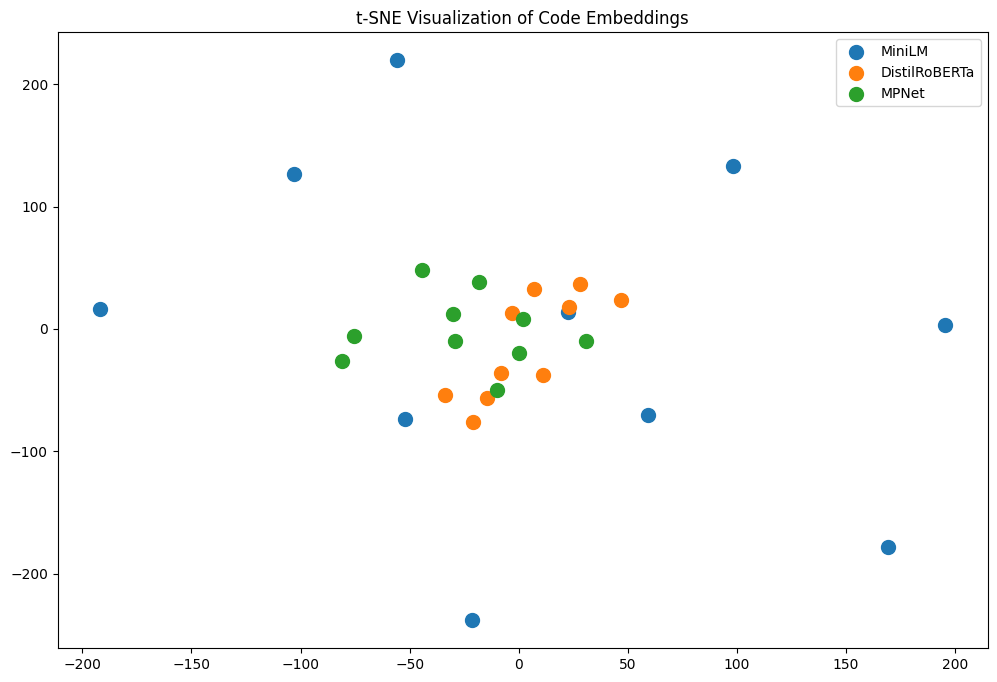

In [7]:
from sklearn.manifold import TSNE

def plot_tsne_fixed(embeddings_dict):
    plt.figure(figsize=(12,8))

    for model_name, emb in embeddings_dict.items():
        tsne = TSNE(n_components=2, random_state=42, perplexity=5)  # < n_samples
        emb_2d = tsne.fit_transform(emb)
        plt.scatter(emb_2d[:,0], emb_2d[:,1], label=model_name, s=100)

    plt.title("t-SNE Visualization of Code Embeddings")
    plt.legend()
    plt.show()

plot_tsne_fixed(embeddings)



Step 8: Compute Cosine Similarity

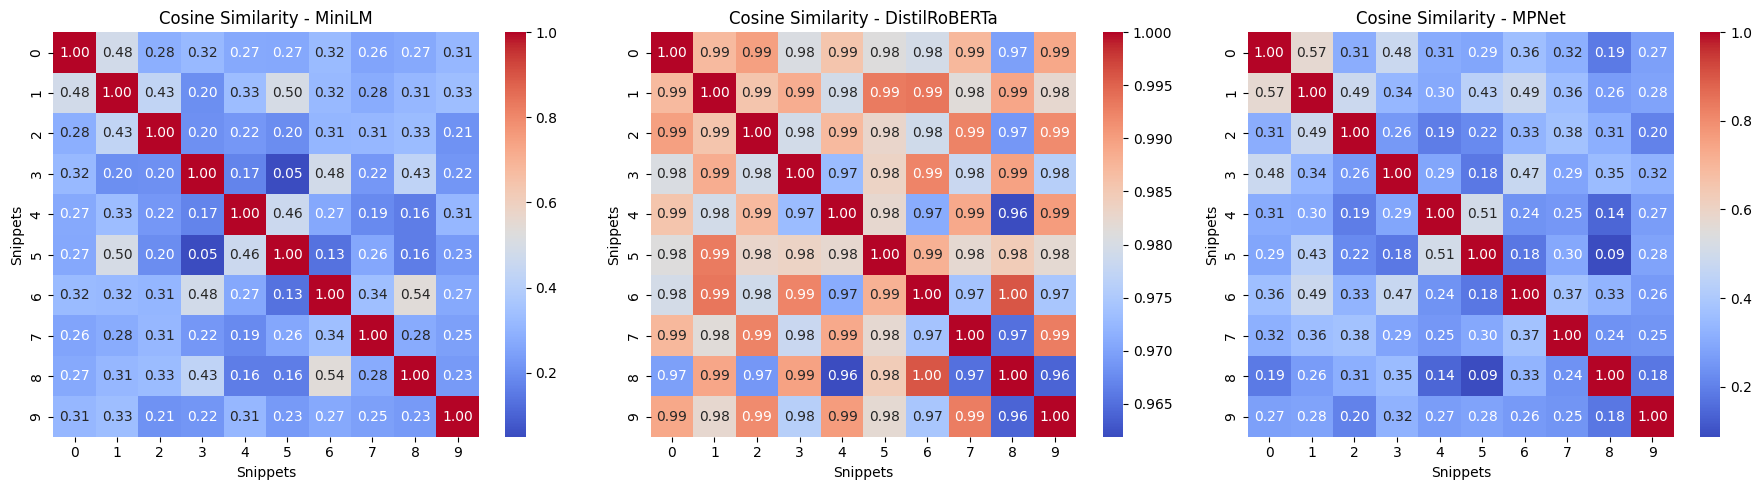

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

def plot_cosine_heatmap(embeddings_dict):
    plt.figure(figsize=(18, 5))

    for i, (model_name, emb) in enumerate(embeddings_dict.items(), 1):
        sim_matrix = cosine_similarity(emb)

        plt.subplot(1, len(embeddings_dict), i)
        sns.heatmap(sim_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title(f"Cosine Similarity - {model_name}")
        plt.xlabel("Snippets")
        plt.ylabel("Snippets")

    plt.tight_layout()
    plt.show()

plot_cosine_heatmap(embeddings)


In [ ]:
import nbformat

# Upload the notebook manually if needed
from google.colab import files
uploaded = files.upload()  # select your notebook file

for nb_file in uploaded.keys():
    nb_path = nb_file
    nb = nbformat.read(nb_path, as_version=5)
    if "widgets" in nb['metadata']:
        del nb['metadata']['widgets']
    nbformat.write(nb, nb_path)
    print(f"Removed widgets metadata from {nb_file}")

# Download the fixed notebook
files.download(nb_path)
